# LLM-архиватор. Эксперименты hyper-prior для steering vector

In [67]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm.notebook import tqdm
import time
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
def clear_memory(var_names=None):
    if var_names is None:
        var_names = [
            'model','tokenizer','enc','dec','logits','probs','inp','ctx',
            'ids','recovered_ids','all_bits','all_original_ids'
        ]
    for var in var_names:
        if var in globals():
            del globals()[var]
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()

## Общие и вспомогательные функции кодирования и декодирования

In [3]:
def probs_to_cdf_int(prob, total=1 << 20):
    cdf = np.cumsum(prob, dtype=np.float64)
    cdf_int = np.floor(cdf * total).astype(np.int64)
    cdf_int = np.maximum.accumulate(cdf_int)
    cdf_int = np.concatenate(([0], cdf_int))
    cdf_int[-1] = total
    return cdf_int

In [4]:
class ArithmeticEncoder:
    def __init__(self, precision=32):
        self.precision = precision
        self.half  = 1 << (precision - 1)
        self.quarter = self.half >> 1
        self.mask  = (1 << precision) - 1
        self.low   = 0
        self.high  = self.mask
        self.pending = 0
        self.out = []

    def update(self, cdf_low, cdf_high, total):
        rng = self.high - self.low + 1
        self.high = self.low + (rng * cdf_high) // total - 1
        self.low  = self.low + (rng * cdf_low)  // total

        # renormalize
        while True:
            # E1: MSB equal
            if self.high < self.half:
                self._emit(0)
            elif self.low >= self.half:
                self._emit(1)
                self.low  -= self.half
                self.high -= self.half
            # E3: underflow
            elif self.low >= self.quarter and self.high < 3 * self.quarter:
                self.pending += 1
                self.low  -= self.quarter
                self.high -= self.quarter
            else:
                break

            # shift out
            self.low   = (self.low   << 1) & self.mask
            self.high  = ((self.high << 1) & self.mask) | 1

    def _emit(self, bit):
        self.out.append(bit)
        for _ in range(self.pending):
            self.out.append(1 - bit)
        self.pending = 0

    def finish(self):
        self.pending += 1
        if self.low < self.quarter:
            self._emit(0)
        else:
            self._emit(1)
        for _ in range(self.precision):
            self.out.append((self.low >> (self.precision - 1)) & 1)
            self.low = (self.low << 1) & self.mask

In [5]:
class ArithmeticDecoder:
    def __init__(self, bits, precision=32):
        self.bits = bits
        self.precision = precision
        self.half  = 1 << (precision - 1)
        self.quarter = self.half >> 1
        self.mask  = (1 << precision) - 1

        self.low   = 0
        self.high  = self.mask
        self.value = 0
        self.idx   = 0
        for _ in range(precision):
            self.value = ((self.value << 1) & self.mask) | self._read()

    def _read(self):
        if self.idx < len(self.bits):
            b = self.bits[self.idx]
            self.idx += 1
            return b
        return 0

    def decode(self, cdf_int, total):
        # find symbol
        rng = self.high - self.low + 1
        scaled = ((self.value - self.low + 1) * total - 1) // rng
        symbol = np.searchsorted(cdf_int, scaled, side='right') - 1

        # narrow interval
        c_lo, c_hi = cdf_int[symbol], cdf_int[symbol+1]
        self.high = self.low + (rng * c_hi) // total - 1
        self.low  = self.low + (rng * c_lo) // total

        # renormalize
        while True:
            if self.high < self.half:
                pass
            elif self.low >= self.half:
                self.value -= self.half
                self.low   -= self.half
                self.high  -= self.half
            elif self.low >= self.quarter and self.high < 3 * self.quarter:
                self.value -= self.quarter
                self.low   -= self.quarter
                self.high  -= self.quarter
            else:
                break

            self.low   = (self.low   << 1) & self.mask
            self.high  = ((self.high << 1) & self.mask) | 1
            self.value = ((self.value << 1) & self.mask) | self._read()

        return symbol

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
def load_model(model_name: str):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name)

    model.eval()
    model.to(device)

    return tokenizer, model

In [8]:
def get_data(size: int, tokenizer, path: str = 'enwik8') -> list[int]:
    with open(path, 'rb') as f:
        data = f.read(size)
    text = data.decode('latin-1')
    return data

In [9]:
class TextChunkDataset(Dataset):
    def __init__(self, path, chunk_size, tokenizer, max_bytes=None):
        raw = open(path, 'rb').read()
        if max_bytes:
            raw = raw[:max_bytes]
        self.chunks = []
        for i in range(0, len(raw), chunk_size):
            text = raw[i:i+chunk_size].decode('latin-1', errors='ignore')
            ids  = tokenizer.encode(text, add_special_tokens=False)
            if len(ids) > 1:
                self.chunks.append(ids)

    def __len__(self):
        return len(self.chunks)

    def __getitem__(self, idx):
        return torch.tensor(self.chunks[idx], dtype=torch.long)

In [10]:
def create_data_loader(
    tokenizer,
    chunk_size: int,
    max_bytes: int
):
    dataset = TextChunkDataset('enwik8', chunk_size, tokenizer, max_bytes=max_bytes)
    loader = DataLoader(dataset, batch_size=1, shuffle=True)
    return dataset, loader

## Обучение soft-prompt

In [11]:
def create_soft_prompt(n_soft: int, model):
    H = model.config.hidden_size
    soft_prompt = nn.Parameter(torch.randn(n_soft, H, device=device))
    return soft_prompt

In [12]:
def train_soft_prompt(
    loader,
    model,
    soft_prompt: torch.nn.Parameter,
    optimizer,
    epochs: int
):
    n_soft = soft_prompt.size(0)

    for epoch in range(1, epochs + 1):
        total_loss = 0.0
        for batch in tqdm(loader, desc=f"Epoch {epoch}"):
            ids = batch[0].to(device)
            L = ids.size(0)
            if L < 2:
                continue

            optimizer.zero_grad()

            embeds = model.get_input_embeddings()(ids.unsqueeze(0))
            sp     = soft_prompt.unsqueeze(0)
            inp_e  = torch.cat([sp, embeds], dim=1)
            attn   = torch.ones(inp_e.shape[:2], device=device)

            labels = torch.full((1, n_soft + L), -100, dtype=torch.long, device=device)
            labels[0, n_soft:] = ids

            out  = model(inputs_embeds=inp_e, attention_mask=attn, labels=labels)
            loss = out.loss
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg = total_loss / len(loader)
        print(f"Epoch {epoch} done — avg loss: {avg:.6f}")

## Кодирование и декодирование с soft-prompt

In [13]:
def encode_with_soft_prompt(
    dataset,
    model,
    soft_prompt: torch.nn.Parameter,
    total: int = 1 << 30
):
    chunk_data = []
    start_time = time.perf_counter()
    max_pe = model.config.max_position_embeddings
    n_soft = soft_prompt.shape[0]

    for ids in tqdm(dataset, desc="Encoding chunks"):
        ids = ids.to(device)
        enc = ArithmeticEncoder()
        sp = soft_prompt.unsqueeze(0)

        for i in tqdm(range(1, ids.size(0)), desc='  Tokens in chunk', leave=False):
            hist = ids[max(0, i - (max_pe - n_soft)):i].unsqueeze(0)
            embeds = model.get_input_embeddings()(hist)
            inp_emb = torch.cat([sp, embeds], dim=1)
            attn_mask = torch.ones(inp_emb.shape[:2], device=device)

            with torch.no_grad():
                out = model(inputs_embeds=inp_emb, attention_mask=attn_mask)
            logits = out.logits[0, -1]
            probs = torch.softmax(logits, dim=-1).cpu().numpy()

            cdf = probs_to_cdf_int(probs, total)
            token_id = ids[i].item()
            enc.update(cdf[token_id], cdf[token_id + 1], total)

        enc.finish()
        chunk_data.append({
            'ids': ids.cpu(),
            'bits': enc.out
        })

    encoding_time = time.perf_counter() - start_time
    print(f"Encoding done in {encoding_time:.2f}s")
    return chunk_data

In [14]:
def decode_with_soft_prompt(
    chunk_data,
    model,
    soft_prompt: torch.nn.Parameter,
    total: int = 1 << 30
):
    start_time = time.perf_counter()
    all_rec = []
    max_pe = model.config.max_position_embeddings
    n_soft = soft_prompt.shape[0]
    sp = soft_prompt.unsqueeze(0)

    for entry in tqdm(chunk_data, desc="Decoding chunks"):
        ids  = entry['ids']
        bits = entry['bits']
        dec  = ArithmeticDecoder(bits)

        rec = [ids[0].item() if hasattr(ids[0], 'item') else ids[0]]
        for i in tqdm(range(1, len(ids)), desc='  Tokens in chunk', leave=False):
            hist = rec[max(0, i - (max_pe - n_soft)):i]
            input_ids = torch.tensor(hist, dtype=torch.long, device=device).unsqueeze(0)
            embeds = model.get_input_embeddings()(input_ids)
            inp_emb = torch.cat([sp, embeds], dim=1)
            attn_mask = torch.ones(inp_emb.shape[:2], device=device)

            with torch.no_grad():
                out = model(inputs_embeds=inp_emb, attention_mask=attn_mask)
            logits = out.logits[0, -1]
            probs  = torch.softmax(logits, dim=-1).cpu().numpy()
            cdf    = probs_to_cdf_int(probs, total)
            rec.append(dec.decode(cdf, total))

        all_rec.extend(rec)

    decoding_time = time.perf_counter() - start_time
    print(f"Decoding done in {decoding_time:.2f}s")
    return all_rec

## Hyper prior

### Гауссов гипер‑приор

In [15]:
def gaussian_hyper_prior(
    sigma: float = 1.0,
    c_min: float = -5.0,
    c_max: float = 5.0,
    n_bins: int = 256,
    total_prior: int = 1 << 30
):
    delta = (c_max - c_min) / n_bins
    # Центры бинов
    bin_centers = np.linspace(c_min + delta/2, c_max - delta/2, n_bins)

    # Вычисляем PMF гауссиана на центрах бинов
    prior_pmf = np.exp(-0.5 * (bin_centers / sigma)**2) / (sigma * np.sqrt(2 * np.pi))
    prior_pmf /= prior_pmf.sum()

    # Интегрируем PMF в целочисленный CDF
    cdf = np.floor(np.cumsum(prior_pmf) * total_prior).astype(np.int64)
    prior_cdf_int = np.concatenate(([0], np.maximum.accumulate(cdf)))
    prior_cdf_int[-1] = total_prior

    return prior_cdf_int, delta, c_min, prior_pmf

In [16]:
def quantize_c(c_tensor, c_min):
    arr = c_tensor.detach().cpu().numpy().flatten()
    idx = np.clip(((arr - c_min)/delta).round().astype(int), 0, 255)
    return idx

def dequantize_c(idx, shape, c_min):
    centers = (np.arange(256) + 0.5) * delta + c_min
    return torch.tensor(centers[idx].reshape(shape), dtype=torch.float32, device=device)

In [17]:
def encode_soft_prompt(soft_prompt, prior_cdf_int, c_min, total_prior = 1 << 30):
    # Квантизуем значения soft_prompt в индексы бинов
    c_idx = quantize_c(soft_prompt, c_min)

    enc = ArithmeticEncoder()
    for s in c_idx:
        lo = prior_cdf_int[s]
        hi = prior_cdf_int[s + 1]
        enc.update(lo, hi, total_prior)
    enc.finish()

    return enc.out

In [18]:
def decode_soft_prompt(
    c_bits: bytes,
    prior_cdf_int: np.ndarray,
    shape: tuple[int, ...],
    c_min,
    total_prior: int = 1 << 30
):
    dec = ArithmeticDecoder(c_bits)
    n_elem = int(np.prod(shape))
    rec_idx = [dec.decode(prior_cdf_int, total_prior) for _ in range(n_elem)]
    rec_idx = np.array(rec_idx, dtype=np.int64)
    soft_prompt_rec = dequantize_c(rec_idx, shape, c_min)
    return soft_prompt_rec

In [19]:
def compare_sequences(orig, dec):
    for k, (o, d) in enumerate(zip(orig, dec)):
        if o != d:
            print(f"❌  Расхождение на позиции {k}: orig={o}  decoded={d}")
            return
    if len(orig) != len(dec):
        print(f"❌  Длины списков отличаются: orig={len(orig)}  decoded={len(dec)}")
        return
    print("✅  Совпадают полностью!")

In [20]:
def compression_stats(data: bytes, enc_out: bytes):
    original_bits = len(data) * 8
    compressed_bits = len(enc_out)
    ratio = compressed_bits / original_bits

    print(f"Исходный размер:   {original_bits} бит")
    print(f"Размер после сжатия: {compressed_bits} бит")
    print(f"Коэффициент сжатия: {ratio:.4f}")

In [21]:
def decode_text_from_ids(ids, tokenizer) -> str:
    return tokenizer.decode(
        ids,
        clean_up_tokenization_spaces=False,
        skip_special_tokens=False
    )

In [22]:
tokenizer, model = load_model('EleutherAI/pythia-70m')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/396 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/567 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/166M [00:00<?, ?B/s]

In [23]:
soft_prompt = create_soft_prompt(200, model)

In [26]:
data = get_data(50000, tokenizer)

In [27]:
dataset, loader = create_data_loader(tokenizer, chunk_size=2000, max_bytes=50000)

In [28]:
model.train()
optimizer = torch.optim.Adam([soft_prompt], lr=5e-4)

In [29]:
train_soft_prompt(loader, model, soft_prompt, optimizer, 500)

Epoch 1:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1 done — avg loss: 3.718327


Epoch 2:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 2 done — avg loss: 3.696431


Epoch 3:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 3 done — avg loss: 3.676888


Epoch 4:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 4 done — avg loss: 3.660330


Epoch 5:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 5 done — avg loss: 3.647663


Epoch 6:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 6 done — avg loss: 3.636772


Epoch 7:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 7 done — avg loss: 3.627116


Epoch 8:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 8 done — avg loss: 3.618083


Epoch 9:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 9 done — avg loss: 3.609579


Epoch 10:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 10 done — avg loss: 3.601610


Epoch 11:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 11 done — avg loss: 3.594023


Epoch 12:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 12 done — avg loss: 3.587252


Epoch 13:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 13 done — avg loss: 3.580990


Epoch 14:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 14 done — avg loss: 3.575544


Epoch 15:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 15 done — avg loss: 3.569901


Epoch 16:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 16 done — avg loss: 3.564296


Epoch 17:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 17 done — avg loss: 3.559307


Epoch 18:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 18 done — avg loss: 3.554340


Epoch 19:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 19 done — avg loss: 3.549677


Epoch 20:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 20 done — avg loss: 3.544580


Epoch 21:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 21 done — avg loss: 3.540100


Epoch 22:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 22 done — avg loss: 3.535596


Epoch 23:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 23 done — avg loss: 3.531864


Epoch 24:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 24 done — avg loss: 3.527865


Epoch 25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 25 done — avg loss: 3.524002


Epoch 26:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 26 done — avg loss: 3.520209


Epoch 27:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 27 done — avg loss: 3.516797


Epoch 28:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 28 done — avg loss: 3.512644


Epoch 29:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 29 done — avg loss: 3.509155


Epoch 30:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 30 done — avg loss: 3.505793


Epoch 31:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 31 done — avg loss: 3.502319


Epoch 32:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 32 done — avg loss: 3.498725


Epoch 33:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 33 done — avg loss: 3.496263


Epoch 34:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 34 done — avg loss: 3.493329


Epoch 35:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 35 done — avg loss: 3.490903


Epoch 36:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 36 done — avg loss: 3.487214


Epoch 37:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 37 done — avg loss: 3.484787


Epoch 38:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 38 done — avg loss: 3.482647


Epoch 39:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 39 done — avg loss: 3.479601


Epoch 40:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 40 done — avg loss: 3.477815


Epoch 41:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 41 done — avg loss: 3.476127


Epoch 42:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 42 done — avg loss: 3.474177


Epoch 43:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 43 done — avg loss: 3.471834


Epoch 44:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 44 done — avg loss: 3.469781


Epoch 45:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 45 done — avg loss: 3.468004


Epoch 46:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 46 done — avg loss: 3.465304


Epoch 47:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 47 done — avg loss: 3.463361


Epoch 48:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 48 done — avg loss: 3.461619


Epoch 49:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 49 done — avg loss: 3.459270


Epoch 50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 50 done — avg loss: 3.457383


Epoch 51:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 51 done — avg loss: 3.455816


Epoch 52:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 52 done — avg loss: 3.453682


Epoch 53:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 53 done — avg loss: 3.451610


Epoch 54:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 54 done — avg loss: 3.450139


Epoch 55:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 55 done — avg loss: 3.448141


Epoch 56:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 56 done — avg loss: 3.446500


Epoch 57:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 57 done — avg loss: 3.444749


Epoch 58:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 58 done — avg loss: 3.442811


Epoch 59:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 59 done — avg loss: 3.441397


Epoch 60:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 60 done — avg loss: 3.439668


Epoch 61:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 61 done — avg loss: 3.438062


Epoch 62:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 62 done — avg loss: 3.436133


Epoch 63:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 63 done — avg loss: 3.434461


Epoch 64:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 64 done — avg loss: 3.432903


Epoch 65:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 65 done — avg loss: 3.430946


Epoch 66:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 66 done — avg loss: 3.429129


Epoch 67:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 67 done — avg loss: 3.427701


Epoch 68:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 68 done — avg loss: 3.425745


Epoch 69:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 69 done — avg loss: 3.423742


Epoch 70:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 70 done — avg loss: 3.422402


Epoch 71:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 71 done — avg loss: 3.420343


Epoch 72:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 72 done — avg loss: 3.418858


Epoch 73:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 73 done — avg loss: 3.417287


Epoch 74:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 74 done — avg loss: 3.414902


Epoch 75:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 75 done — avg loss: 3.412791


Epoch 76:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 76 done — avg loss: 3.411027


Epoch 77:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 77 done — avg loss: 3.409244


Epoch 78:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 78 done — avg loss: 3.407625


Epoch 79:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 79 done — avg loss: 3.406067


Epoch 80:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 80 done — avg loss: 3.404272


Epoch 81:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 81 done — avg loss: 3.402526


Epoch 82:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 82 done — avg loss: 3.401029


Epoch 83:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 83 done — avg loss: 3.399504


Epoch 84:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 84 done — avg loss: 3.398395


Epoch 85:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 85 done — avg loss: 3.396383


Epoch 86:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 86 done — avg loss: 3.394346


Epoch 87:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 87 done — avg loss: 3.392923


Epoch 88:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 88 done — avg loss: 3.391428


Epoch 89:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 89 done — avg loss: 3.389452


Epoch 90:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 90 done — avg loss: 3.388301


Epoch 91:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 91 done — avg loss: 3.386920


Epoch 92:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 92 done — avg loss: 3.384815


Epoch 93:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 93 done — avg loss: 3.383104


Epoch 94:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 94 done — avg loss: 3.381009


Epoch 95:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 95 done — avg loss: 3.379571


Epoch 96:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 96 done — avg loss: 3.378802


Epoch 97:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 97 done — avg loss: 3.376828


Epoch 98:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 98 done — avg loss: 3.375130


Epoch 99:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 99 done — avg loss: 3.373197


Epoch 100:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 100 done — avg loss: 3.372432


Epoch 101:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 101 done — avg loss: 3.370852


Epoch 102:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 102 done — avg loss: 3.369606


Epoch 103:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 103 done — avg loss: 3.368014


Epoch 104:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 104 done — avg loss: 3.366585


Epoch 105:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 105 done — avg loss: 3.364598


Epoch 106:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 106 done — avg loss: 3.362481


Epoch 107:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 107 done — avg loss: 3.361005


Epoch 108:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 108 done — avg loss: 3.360002


Epoch 109:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 109 done — avg loss: 3.358519


Epoch 110:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 110 done — avg loss: 3.356751


Epoch 111:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 111 done — avg loss: 3.355274


Epoch 112:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 112 done — avg loss: 3.353516


Epoch 113:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 113 done — avg loss: 3.352264


Epoch 114:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 114 done — avg loss: 3.351016


Epoch 115:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 115 done — avg loss: 3.348718


Epoch 116:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 116 done — avg loss: 3.346987


Epoch 117:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 117 done — avg loss: 3.346054


Epoch 118:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 118 done — avg loss: 3.344424


Epoch 119:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 119 done — avg loss: 3.342660


Epoch 120:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 120 done — avg loss: 3.341947


Epoch 121:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 121 done — avg loss: 3.340054


Epoch 122:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 122 done — avg loss: 3.338657


Epoch 123:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 123 done — avg loss: 3.337363


Epoch 124:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 124 done — avg loss: 3.335898


Epoch 125:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 125 done — avg loss: 3.334151


Epoch 126:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 126 done — avg loss: 3.332691


Epoch 127:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 127 done — avg loss: 3.331596


Epoch 128:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 128 done — avg loss: 3.329775


Epoch 129:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 129 done — avg loss: 3.327871


Epoch 130:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 130 done — avg loss: 3.326734


Epoch 131:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 131 done — avg loss: 3.325133


Epoch 132:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 132 done — avg loss: 3.324153


Epoch 133:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 133 done — avg loss: 3.322871


Epoch 134:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 134 done — avg loss: 3.321124


Epoch 135:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 135 done — avg loss: 3.319690


Epoch 136:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 136 done — avg loss: 3.318395


Epoch 137:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 137 done — avg loss: 3.316427


Epoch 138:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 138 done — avg loss: 3.315076


Epoch 139:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 139 done — avg loss: 3.313996


Epoch 140:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 140 done — avg loss: 3.312758


Epoch 141:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 141 done — avg loss: 3.310896


Epoch 142:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 142 done — avg loss: 3.308914


Epoch 143:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 143 done — avg loss: 3.307955


Epoch 144:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 144 done — avg loss: 3.307149


Epoch 145:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 145 done — avg loss: 3.305224


Epoch 146:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 146 done — avg loss: 3.302738


Epoch 147:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 147 done — avg loss: 3.301301


Epoch 148:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 148 done — avg loss: 3.299675


Epoch 149:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 149 done — avg loss: 3.298237


Epoch 150:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 150 done — avg loss: 3.296429


Epoch 151:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 151 done — avg loss: 3.294926


Epoch 152:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 152 done — avg loss: 3.293712


Epoch 153:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 153 done — avg loss: 3.292250


Epoch 154:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 154 done — avg loss: 3.291008


Epoch 155:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 155 done — avg loss: 3.289818


Epoch 156:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 156 done — avg loss: 3.288396


Epoch 157:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 157 done — avg loss: 3.286794


Epoch 158:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 158 done — avg loss: 3.285227


Epoch 159:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 159 done — avg loss: 3.283328


Epoch 160:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 160 done — avg loss: 3.282285


Epoch 161:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 161 done — avg loss: 3.281048


Epoch 162:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 162 done — avg loss: 3.280010


Epoch 163:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 163 done — avg loss: 3.278368


Epoch 164:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 164 done — avg loss: 3.276678


Epoch 165:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 165 done — avg loss: 3.274994


Epoch 166:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 166 done — avg loss: 3.273894


Epoch 167:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 167 done — avg loss: 3.272284


Epoch 168:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 168 done — avg loss: 3.270648


Epoch 169:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 169 done — avg loss: 3.269934


Epoch 170:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 170 done — avg loss: 3.268978


Epoch 171:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 171 done — avg loss: 3.267510


Epoch 172:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 172 done — avg loss: 3.264888


Epoch 173:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 173 done — avg loss: 3.263217


Epoch 174:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 174 done — avg loss: 3.263213


Epoch 175:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 175 done — avg loss: 3.261329


Epoch 176:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 176 done — avg loss: 3.259364


Epoch 177:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 177 done — avg loss: 3.258311


Epoch 178:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 178 done — avg loss: 3.256927


Epoch 179:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 179 done — avg loss: 3.255521


Epoch 180:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 180 done — avg loss: 3.254096


Epoch 181:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 181 done — avg loss: 3.253148


Epoch 182:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 182 done — avg loss: 3.252037


Epoch 183:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 183 done — avg loss: 3.250800


Epoch 184:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 184 done — avg loss: 3.248930


Epoch 185:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 185 done — avg loss: 3.246968


Epoch 186:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 186 done — avg loss: 3.245611


Epoch 187:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 187 done — avg loss: 3.244483


Epoch 188:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 188 done — avg loss: 3.243082


Epoch 189:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 189 done — avg loss: 3.241852


Epoch 190:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 190 done — avg loss: 3.240182


Epoch 191:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 191 done — avg loss: 3.238653


Epoch 192:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 192 done — avg loss: 3.237580


Epoch 193:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 193 done — avg loss: 3.236971


Epoch 194:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 194 done — avg loss: 3.235222


Epoch 195:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 195 done — avg loss: 3.233699


Epoch 196:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 196 done — avg loss: 3.232030


Epoch 197:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 197 done — avg loss: 3.230902


Epoch 198:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 198 done — avg loss: 3.230011


Epoch 199:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 199 done — avg loss: 3.228592


Epoch 200:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 200 done — avg loss: 3.229743


Epoch 201:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 201 done — avg loss: 3.228615


Epoch 202:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 202 done — avg loss: 3.225371


Epoch 203:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 203 done — avg loss: 3.223392


Epoch 204:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 204 done — avg loss: 3.221665


Epoch 205:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 205 done — avg loss: 3.220026


Epoch 206:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 206 done — avg loss: 3.218686


Epoch 207:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 207 done — avg loss: 3.218504


Epoch 208:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 208 done — avg loss: 3.217546


Epoch 209:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 209 done — avg loss: 3.216034


Epoch 210:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 210 done — avg loss: 3.214185


Epoch 211:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 211 done — avg loss: 3.212853


Epoch 212:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 212 done — avg loss: 3.212008


Epoch 213:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 213 done — avg loss: 3.209791


Epoch 214:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 214 done — avg loss: 3.209184


Epoch 215:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 215 done — avg loss: 3.207428


Epoch 216:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 216 done — avg loss: 3.206239


Epoch 217:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 217 done — avg loss: 3.205419


Epoch 218:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 218 done — avg loss: 3.204236


Epoch 219:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 219 done — avg loss: 3.203137


Epoch 220:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 220 done — avg loss: 3.200680


Epoch 221:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 221 done — avg loss: 3.201167


Epoch 222:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 222 done — avg loss: 3.199196


Epoch 223:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 223 done — avg loss: 3.197313


Epoch 224:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 224 done — avg loss: 3.196202


Epoch 225:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 225 done — avg loss: 3.195547


Epoch 226:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 226 done — avg loss: 3.193837


Epoch 227:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 227 done — avg loss: 3.192831


Epoch 228:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 228 done — avg loss: 3.194228


Epoch 229:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 229 done — avg loss: 3.193643


Epoch 230:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 230 done — avg loss: 3.190207


Epoch 231:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 231 done — avg loss: 3.187270


Epoch 232:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 232 done — avg loss: 3.186495


Epoch 233:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 233 done — avg loss: 3.185207


Epoch 234:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 234 done — avg loss: 3.184280


Epoch 235:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 235 done — avg loss: 3.182952


Epoch 236:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 236 done — avg loss: 3.182431


Epoch 237:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 237 done — avg loss: 3.181212


Epoch 238:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 238 done — avg loss: 3.179226


Epoch 239:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 239 done — avg loss: 3.177556


Epoch 240:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 240 done — avg loss: 3.176671


Epoch 241:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 241 done — avg loss: 3.176426


Epoch 242:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 242 done — avg loss: 3.174998


Epoch 243:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 243 done — avg loss: 3.174177


Epoch 244:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 244 done — avg loss: 3.171696


Epoch 245:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 245 done — avg loss: 3.169936


Epoch 246:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 246 done — avg loss: 3.168972


Epoch 247:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 247 done — avg loss: 3.168142


Epoch 248:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 248 done — avg loss: 3.167888


Epoch 249:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 249 done — avg loss: 3.167506


Epoch 250:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 250 done — avg loss: 3.166810


Epoch 251:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 251 done — avg loss: 3.163684


Epoch 252:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 252 done — avg loss: 3.162612


Epoch 253:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 253 done — avg loss: 3.160947


Epoch 254:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 254 done — avg loss: 3.159196


Epoch 255:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 255 done — avg loss: 3.158776


Epoch 256:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 256 done — avg loss: 3.157363


Epoch 257:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 257 done — avg loss: 3.156273


Epoch 258:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 258 done — avg loss: 3.154815


Epoch 259:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 259 done — avg loss: 3.154245


Epoch 260:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 260 done — avg loss: 3.152323


Epoch 261:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 261 done — avg loss: 3.151375


Epoch 262:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 262 done — avg loss: 3.149244


Epoch 263:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 263 done — avg loss: 3.148473


Epoch 264:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 264 done — avg loss: 3.146953


Epoch 265:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 265 done — avg loss: 3.146507


Epoch 266:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 266 done — avg loss: 3.145699


Epoch 267:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 267 done — avg loss: 3.146842


Epoch 268:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 268 done — avg loss: 3.145560


Epoch 269:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 269 done — avg loss: 3.143119


Epoch 270:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 270 done — avg loss: 3.140872


Epoch 271:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 271 done — avg loss: 3.139119


Epoch 272:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 272 done — avg loss: 3.137673


Epoch 273:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 273 done — avg loss: 3.136170


Epoch 274:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 274 done — avg loss: 3.135604


Epoch 275:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 275 done — avg loss: 3.134419


Epoch 276:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 276 done — avg loss: 3.133368


Epoch 277:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 277 done — avg loss: 3.131580


Epoch 278:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 278 done — avg loss: 3.131005


Epoch 279:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 279 done — avg loss: 3.130112


Epoch 280:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 280 done — avg loss: 3.128574


Epoch 281:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 281 done — avg loss: 3.127448


Epoch 282:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 282 done — avg loss: 3.125575


Epoch 283:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 283 done — avg loss: 3.125208


Epoch 284:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 284 done — avg loss: 3.123859


Epoch 285:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 285 done — avg loss: 3.122691


Epoch 286:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 286 done — avg loss: 3.122285


Epoch 287:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 287 done — avg loss: 3.121430


Epoch 288:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 288 done — avg loss: 3.119040


Epoch 289:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 289 done — avg loss: 3.117455


Epoch 290:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 290 done — avg loss: 3.117301


Epoch 291:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 291 done — avg loss: 3.116487


Epoch 292:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 292 done — avg loss: 3.115652


Epoch 293:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 293 done — avg loss: 3.114149


Epoch 294:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 294 done — avg loss: 3.112284


Epoch 295:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 295 done — avg loss: 3.110508


Epoch 296:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 296 done — avg loss: 3.110140


Epoch 297:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 297 done — avg loss: 3.108925


Epoch 298:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 298 done — avg loss: 3.108135


Epoch 299:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 299 done — avg loss: 3.107842


Epoch 300:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 300 done — avg loss: 3.106571


Epoch 301:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 301 done — avg loss: 3.105136


Epoch 302:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 302 done — avg loss: 3.103719


Epoch 303:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 303 done — avg loss: 3.103048


Epoch 304:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 304 done — avg loss: 3.101116


Epoch 305:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 305 done — avg loss: 3.099574


Epoch 306:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 306 done — avg loss: 3.098224


Epoch 307:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 307 done — avg loss: 3.097066


Epoch 308:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 308 done — avg loss: 3.096752


Epoch 309:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 309 done — avg loss: 3.095554


Epoch 310:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 310 done — avg loss: 3.094860


Epoch 311:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 311 done — avg loss: 3.092408


Epoch 312:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 312 done — avg loss: 3.092019


Epoch 313:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 313 done — avg loss: 3.091428


Epoch 314:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 314 done — avg loss: 3.089378


Epoch 315:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 315 done — avg loss: 3.089330


Epoch 316:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 316 done — avg loss: 3.088048


Epoch 317:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 317 done — avg loss: 3.086904


Epoch 318:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 318 done — avg loss: 3.086252


Epoch 319:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 319 done — avg loss: 3.084669


Epoch 320:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 320 done — avg loss: 3.083118


Epoch 321:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 321 done — avg loss: 3.081718


Epoch 322:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 322 done — avg loss: 3.081956


Epoch 323:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 323 done — avg loss: 3.080695


Epoch 324:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 324 done — avg loss: 3.078970


Epoch 325:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 325 done — avg loss: 3.077763


Epoch 326:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 326 done — avg loss: 3.077192


Epoch 327:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 327 done — avg loss: 3.076653


Epoch 328:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 328 done — avg loss: 3.075596


Epoch 329:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 329 done — avg loss: 3.074013


Epoch 330:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 330 done — avg loss: 3.073300


Epoch 331:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 331 done — avg loss: 3.073864


Epoch 332:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 332 done — avg loss: 3.071590


Epoch 333:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 333 done — avg loss: 3.069235


Epoch 334:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 334 done — avg loss: 3.068562


Epoch 335:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 335 done — avg loss: 3.068239


Epoch 336:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 336 done — avg loss: 3.066648


Epoch 337:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 337 done — avg loss: 3.066474


Epoch 338:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 338 done — avg loss: 3.065490


Epoch 339:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 339 done — avg loss: 3.064027


Epoch 340:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 340 done — avg loss: 3.063285


Epoch 341:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 341 done — avg loss: 3.061435


Epoch 342:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 342 done — avg loss: 3.059333


Epoch 343:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 343 done — avg loss: 3.059459


Epoch 344:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 344 done — avg loss: 3.059481


Epoch 345:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 345 done — avg loss: 3.059117


Epoch 346:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 346 done — avg loss: 3.058788


Epoch 347:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 347 done — avg loss: 3.056162


Epoch 348:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 348 done — avg loss: 3.055670


Epoch 349:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 349 done — avg loss: 3.053123


Epoch 350:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 350 done — avg loss: 3.051800


Epoch 351:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 351 done — avg loss: 3.050825


Epoch 352:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 352 done — avg loss: 3.049845


Epoch 353:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 353 done — avg loss: 3.049373


Epoch 354:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 354 done — avg loss: 3.047912


Epoch 355:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 355 done — avg loss: 3.046523


Epoch 356:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 356 done — avg loss: 3.047229


Epoch 357:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 357 done — avg loss: 3.045939


Epoch 358:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 358 done — avg loss: 3.043380


Epoch 359:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 359 done — avg loss: 3.043040


Epoch 360:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 360 done — avg loss: 3.041336


Epoch 361:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 361 done — avg loss: 3.040717


Epoch 362:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 362 done — avg loss: 3.039105


Epoch 363:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 363 done — avg loss: 3.038836


Epoch 364:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 364 done — avg loss: 3.037286


Epoch 365:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 365 done — avg loss: 3.036654


Epoch 366:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 366 done — avg loss: 3.036594


Epoch 367:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 367 done — avg loss: 3.036090


Epoch 368:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 368 done — avg loss: 3.034574


Epoch 369:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 369 done — avg loss: 3.033216


Epoch 370:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 370 done — avg loss: 3.032209


Epoch 371:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 371 done — avg loss: 3.033756


Epoch 372:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 372 done — avg loss: 3.031587


Epoch 373:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 373 done — avg loss: 3.029809


Epoch 374:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 374 done — avg loss: 3.028209


Epoch 375:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 375 done — avg loss: 3.027719


Epoch 376:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 376 done — avg loss: 3.027821


Epoch 377:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 377 done — avg loss: 3.025676


Epoch 378:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 378 done — avg loss: 3.024164


Epoch 379:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 379 done — avg loss: 3.022596


Epoch 380:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 380 done — avg loss: 3.021716


Epoch 381:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 381 done — avg loss: 3.020992


Epoch 382:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 382 done — avg loss: 3.020111


Epoch 383:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 383 done — avg loss: 3.019033


Epoch 384:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 384 done — avg loss: 3.019720


Epoch 385:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 385 done — avg loss: 3.017809


Epoch 386:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 386 done — avg loss: 3.015898


Epoch 387:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 387 done — avg loss: 3.015148


Epoch 388:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 388 done — avg loss: 3.017105


Epoch 389:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 389 done — avg loss: 3.016127


Epoch 390:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 390 done — avg loss: 3.013179


Epoch 391:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 391 done — avg loss: 3.011088


Epoch 392:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 392 done — avg loss: 3.009889


Epoch 393:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 393 done — avg loss: 3.009578


Epoch 394:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 394 done — avg loss: 3.008788


Epoch 395:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 395 done — avg loss: 3.008254


Epoch 396:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 396 done — avg loss: 3.006921


Epoch 397:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 397 done — avg loss: 3.005116


Epoch 398:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 398 done — avg loss: 3.005706


Epoch 399:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 399 done — avg loss: 3.004288


Epoch 400:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 400 done — avg loss: 3.003476


Epoch 401:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 401 done — avg loss: 3.001851


Epoch 402:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 402 done — avg loss: 3.002085


Epoch 403:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 403 done — avg loss: 3.000274


Epoch 404:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 404 done — avg loss: 2.998995


Epoch 405:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 405 done — avg loss: 2.998982


Epoch 406:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 406 done — avg loss: 2.997201


Epoch 407:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 407 done — avg loss: 2.997106


Epoch 408:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 408 done — avg loss: 2.995384


Epoch 409:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 409 done — avg loss: 2.994352


Epoch 410:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 410 done — avg loss: 2.993660


Epoch 411:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 411 done — avg loss: 2.992468


Epoch 412:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 412 done — avg loss: 2.991705


Epoch 413:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 413 done — avg loss: 2.991299


Epoch 414:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 414 done — avg loss: 2.989580


Epoch 415:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 415 done — avg loss: 2.988468


Epoch 416:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 416 done — avg loss: 2.987123


Epoch 417:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 417 done — avg loss: 2.987444


Epoch 418:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 418 done — avg loss: 2.987514


Epoch 419:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 419 done — avg loss: 2.985168


Epoch 420:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 420 done — avg loss: 2.984366


Epoch 421:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 421 done — avg loss: 2.982888


Epoch 422:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 422 done — avg loss: 2.983175


Epoch 423:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 423 done — avg loss: 2.982184


Epoch 424:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 424 done — avg loss: 2.981448


Epoch 425:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 425 done — avg loss: 2.979555


Epoch 426:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 426 done — avg loss: 2.978935


Epoch 427:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 427 done — avg loss: 2.978213


Epoch 428:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 428 done — avg loss: 2.976839


Epoch 429:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 429 done — avg loss: 2.975636


Epoch 430:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 430 done — avg loss: 2.975881


Epoch 431:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 431 done — avg loss: 2.976307


Epoch 432:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 432 done — avg loss: 2.975897


Epoch 433:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 433 done — avg loss: 2.973479


Epoch 434:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 434 done — avg loss: 2.973821


Epoch 435:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 435 done — avg loss: 2.971280


Epoch 436:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 436 done — avg loss: 2.970006


Epoch 437:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 437 done — avg loss: 2.968930


Epoch 438:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 438 done — avg loss: 2.967591


Epoch 439:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 439 done — avg loss: 2.968135


Epoch 440:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 440 done — avg loss: 2.966860


Epoch 441:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 441 done — avg loss: 2.965851


Epoch 442:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 442 done — avg loss: 2.964081


Epoch 443:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 443 done — avg loss: 2.963759


Epoch 444:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 444 done — avg loss: 2.963611


Epoch 445:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 445 done — avg loss: 2.961786


Epoch 446:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 446 done — avg loss: 2.961904


Epoch 447:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 447 done — avg loss: 2.959660


Epoch 448:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 448 done — avg loss: 2.959698


Epoch 449:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 449 done — avg loss: 2.958184


Epoch 450:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 450 done — avg loss: 2.957065


Epoch 451:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 451 done — avg loss: 2.956667


Epoch 452:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 452 done — avg loss: 2.956333


Epoch 453:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 453 done — avg loss: 2.955076


Epoch 454:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 454 done — avg loss: 2.953857


Epoch 455:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 455 done — avg loss: 2.953751


Epoch 456:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 456 done — avg loss: 2.951807


Epoch 457:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 457 done — avg loss: 2.951797


Epoch 458:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 458 done — avg loss: 2.949915


Epoch 459:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 459 done — avg loss: 2.951624


Epoch 460:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 460 done — avg loss: 2.949908


Epoch 461:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 461 done — avg loss: 2.947307


Epoch 462:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 462 done — avg loss: 2.946636


Epoch 463:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 463 done — avg loss: 2.945778


Epoch 464:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 464 done — avg loss: 2.944298


Epoch 465:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 465 done — avg loss: 2.943987


Epoch 466:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 466 done — avg loss: 2.942720


Epoch 467:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 467 done — avg loss: 2.941606


Epoch 468:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 468 done — avg loss: 2.940956


Epoch 469:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 469 done — avg loss: 2.940689


Epoch 470:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 470 done — avg loss: 2.939600


Epoch 471:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 471 done — avg loss: 2.938793


Epoch 472:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 472 done — avg loss: 2.939342


Epoch 473:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 473 done — avg loss: 2.938301


Epoch 474:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 474 done — avg loss: 2.936193


Epoch 475:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 475 done — avg loss: 2.934954


Epoch 476:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 476 done — avg loss: 2.934640


Epoch 477:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 477 done — avg loss: 2.934456


Epoch 478:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 478 done — avg loss: 2.932181


Epoch 479:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 479 done — avg loss: 2.932002


Epoch 480:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 480 done — avg loss: 2.931903


Epoch 481:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 481 done — avg loss: 2.932097


Epoch 482:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 482 done — avg loss: 2.929974


Epoch 483:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 483 done — avg loss: 2.929420


Epoch 484:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 484 done — avg loss: 2.927369


Epoch 485:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 485 done — avg loss: 2.926350


Epoch 486:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 486 done — avg loss: 2.927223


Epoch 487:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 487 done — avg loss: 2.925926


Epoch 488:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 488 done — avg loss: 2.926332


Epoch 489:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 489 done — avg loss: 2.927731


Epoch 490:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 490 done — avg loss: 2.924864


Epoch 491:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 491 done — avg loss: 2.920854


Epoch 492:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 492 done — avg loss: 2.920202


Epoch 493:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 493 done — avg loss: 2.921258


Epoch 494:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 494 done — avg loss: 2.919869


Epoch 495:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 495 done — avg loss: 2.917993


Epoch 496:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 496 done — avg loss: 2.920116


Epoch 497:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 497 done — avg loss: 2.917318


Epoch 498:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 498 done — avg loss: 2.917296


Epoch 499:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 499 done — avg loss: 2.914563


Epoch 500:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 500 done — avg loss: 2.914057


In [30]:
prior_cdf_int, delta, c_min, prior_pmf = gaussian_hyper_prior(sigma=1.0, c_min=-5.0, c_max=5.0, n_bins=256)

In [31]:
c_bits = encode_soft_prompt(soft_prompt, prior_cdf_int, c_min)

In [32]:
soft_prompt_rec = decode_soft_prompt(c_bits, prior_cdf_int, soft_prompt.shape, c_min)

In [33]:
model.eval();

In [34]:
chunk_data = encode_with_soft_prompt(
    dataset, model, soft_prompt_rec)

Encoding chunks:   0%|          | 0/25 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/668 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/732 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/572 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/589 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/577 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/546 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/453 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/505 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/453 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/568 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/500 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/511 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/487 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/456 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/465 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/514 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/426 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/537 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/494 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/600 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/473 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/494 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/495 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/442 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/452 [00:00<?, ?it/s]

Encoding done in 196.62s


In [35]:
all_rec = decode_with_soft_prompt(
    chunk_data, model, soft_prompt_rec)

Decoding chunks:   0%|          | 0/25 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/668 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/732 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/572 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/589 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/577 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/546 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/453 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/505 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/453 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/568 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/500 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/511 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/487 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/456 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/465 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/514 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/426 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/537 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/494 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/600 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/473 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/494 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/495 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/442 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/452 [00:00<?, ?it/s]

Decoding done in 197.42s


In [36]:
orig_ids = sum((entry['ids'].tolist() for entry in chunk_data), [])
encoded_output = sum([entry['bits'] for entry in chunk_data], [])

In [37]:
compare_sequences(orig_ids, all_rec)

✅  Совпадают полностью!


In [38]:
compression_stats(data, encoded_output)

Исходный размер:   400000 бит
Размер после сжатия: 54279 бит
Коэффициент сжатия: 0.1357


In [41]:
def steering_vector_stats_gauss(
    soft_prompt,
    soft_prompt_rec,
    bits_coded,
    prior_pmf,
    sigma, c_min, c_max, n_bins):

    num_dims = soft_prompt.numel()
    bits_data = bits_coded
    bits_per_dim = bits_data / num_dims

    pmf_pos = prior_pmf[prior_pmf > 0]
    import numpy as np
    H_coord = -np.sum(pmf_pos * np.log2(pmf_pos))
    H_total = H_coord * num_dims

    D = len(soft_prompt.shape)
    metadata_bits = (3 + 1 + D) * 32
    total_bits = bits_data + metadata_bits

    rec = torch.as_tensor(soft_prompt_rec,
                         device=soft_prompt.device,
                         dtype=soft_prompt.dtype)
    mse = torch.mean((soft_prompt - rec) ** 2).item()

    original_bits = num_dims * 32
    comp_ratio = total_bits / original_bits

    print(f"Число координат:            {num_dims}")
    print(f"Битов для данных:           {bits_data}")
    print(f"Битов/коорд (данные):       {bits_per_dim:.4f}")
    print(f"Метаданных (гиперпараметры):{metadata_bits} бит")
    print(f"Всего бит:                  {total_bits}")
    print(f"Теорет. энтр. на коорд:     {H_coord:.4f} бит")
    print(f"Теорет. энтр. всего:        {H_total:.2f} бит")
    print(f"MSE:                        {mse:.6e}")
    print(f"Коэффициент компрессии:     {comp_ratio:.4f}")

    return total_bits, mse


In [42]:
total_bits_gauss, mse_gauss =steering_vector_stats_gauss(
    soft_prompt=soft_prompt,
    soft_prompt_rec=soft_prompt_rec,
    bits_coded=len(c_bits),
    prior_pmf=prior_pmf,
    sigma=1.0,
    c_min=c_min,
    c_max=5.0,
    n_bins=256
)

Число координат:            102400
Битов для данных:           690204
Битов/коорд (данные):       6.7403
Метаданных (гиперпараметры):192 бит
Всего бит:                  690396
Теорет. энтр. на коорд:     6.7252 бит
Теорет. энтр. всего:        688655.97 бит
MSE:                        5.107074e-04
Коэффициент компрессии:     0.2107


### Эмпирический гипер‑приор

In [43]:
def empirical_hyper_prior(soft_prompt, bins: int = 256, total_prior: int = 1 << 30,
                          lo_pct: float = 1.0, hi_pct: float = 99.0):
    # Выгружаем значения в numpy и распрямляем
    vals = soft_prompt.detach().cpu().numpy().flatten()

    # Берём 1–99-й перцентиль
    vmin, vmax = np.percentile(vals, [lo_pct, hi_pct])

    # Считаем гистограмму и нормируем в PMF
    hist, _ = np.histogram(vals, bins=bins, range=(vmin, vmax))
    prior_pmf = hist.astype(float)
    prior_pmf /= prior_pmf.sum()

    # Интегрируем PMF в CDF и масштабируем
    cdf = np.floor(np.cumsum(prior_pmf) * total_prior).astype(np.int64)
    # Добавляем 0 в начало и обеспечиваем неубывающую функцию
    prior_cdf_int = np.concatenate(([0], np.maximum.accumulate(cdf)))
    # Гарантируем, что последний элемент равен total_prior
    prior_cdf_int[-1] = total_prior

    # Ширина одного бина
    delta = (vmax - vmin) / bins

    return prior_cdf_int, delta, vmin, prior_pmf

In [44]:
prior_cdf_int, delta, c_min, prior_pmf = empirical_hyper_prior(soft_prompt)

In [45]:
c_bits = encode_soft_prompt(soft_prompt, prior_cdf_int, c_min)

In [46]:
soft_prompt_rec = decode_soft_prompt(c_bits, prior_cdf_int, soft_prompt.shape, c_min)

In [49]:
def steering_vector_stats_empirical(
    soft_prompt,
    soft_prompt_rec,
    bits_coded,
    prior_pmf,
    prior_cdf_int,
    c_min
):
    import numpy as np
    import torch

    num_dims    = soft_prompt.numel()
    bits_data   = bits_coded
    bits_per_dim= bits_data / num_dims

    pmf_pos = prior_pmf[prior_pmf > 0]
    H_coord = -np.sum(pmf_pos * np.log2(pmf_pos))
    H_total = H_coord * num_dims

    rec = torch.as_tensor(soft_prompt_rec,
                         device=soft_prompt.device,
                         dtype=soft_prompt.dtype)
    mse = torch.mean((soft_prompt - rec) ** 2).item()

    D = len(soft_prompt.shape)
    metadata_bits = (len(prior_cdf_int) + 1 + D) * 32

    total_bits = bits_data + metadata_bits

    original_bits = num_dims * 32
    comp_ratio    = total_bits / original_bits

    print(f"Число координат:               {num_dims}")
    print(f"Битов для данных (c_bits):      {bits_data}")
    print(f"Битов/коорд (данные):          {bits_per_dim:.4f}")
    print(f"Размер метаданных:             {metadata_bits} бит")
    print(f"Всего бит (данные+метаданные): {total_bits}")
    print(f"Теорет. энтр. на коорд:        {H_coord:.4f} бит")
    print(f"Теорет. энтр. всего:           {H_total:.2f} бит")
    print(f"MSE восстановления:           {mse:.6e}")
    print(f"Коэффициент компрессии:        {comp_ratio:.4f}")

    return total_bits, mse


In [50]:
total_bits_emp, mse_emp = steering_vector_stats_empirical(
    soft_prompt,
    soft_prompt_rec,
    bits_coded=len(c_bits),
    prior_pmf=prior_pmf,
    prior_cdf_int=prior_cdf_int,
    c_min=c_min
)

Число координат:               102400
Битов для данных (c_bits):      796276
Битов/коорд (данные):          7.7761
Размер метаданных:             8320 бит
Всего бит (данные+метаданные): 804596
Теорет. энтр. на коорд:        7.7136 бит
Теорет. энтр. всего:           789871.63 бит
MSE восстановления:           4.488599e-03
Коэффициент компрессии:        0.2455


In [51]:
chunk_data = encode_with_soft_prompt(
    dataset, model, soft_prompt_rec)

Encoding chunks:   0%|          | 0/25 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/668 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/732 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/572 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/589 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/577 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/546 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/453 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/505 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/453 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/568 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/500 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/511 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/487 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/456 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/465 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/514 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/426 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/537 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/494 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/600 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/473 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/494 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/495 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/442 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/452 [00:00<?, ?it/s]

Encoding done in 204.55s


In [52]:
all_rec = decode_with_soft_prompt(
    chunk_data, model, soft_prompt_rec)

Decoding chunks:   0%|          | 0/25 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/668 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/732 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/572 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/589 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/577 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/546 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/453 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/505 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/453 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/568 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/500 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/511 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/487 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/456 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/465 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/514 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/426 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/537 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/494 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/600 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/473 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/494 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/495 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/442 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/452 [00:00<?, ?it/s]

Decoding done in 200.35s


In [53]:
orig_ids = sum((entry['ids'].tolist() for entry in chunk_data), [])
encoded_output = sum([entry['bits'] for entry in chunk_data], [])

In [54]:
compare_sequences(orig_ids, all_rec)

✅  Совпадают полностью!


In [55]:
compression_stats(data, encoded_output)

Исходный размер:   400000 бит
Размер после сжатия: 54874 бит
Коэффициент сжатия: 0.1372


### Lloyd–Max (1D k‑means) гипер‑приор

In [56]:
def lloyd_max_hyper_prior(soft_prompt,
                          bins: int = 256,
                          total_prior: int = 1 << 30,
                          sample_size: int = 100_000,
                          random_state: int = 0):
    vals = soft_prompt.detach().cpu().numpy().flatten()
    N    = len(vals)

    # Берём подвыборку для кластеризации
    if N > sample_size:
        idx_sample = np.random.choice(N, sample_size, replace=False)
        sample = vals[idx_sample].reshape(-1, 1)
    else:
        sample = vals.reshape(-1, 1)

    # KMeans → Lloyd‑Max центроиды
    kmeans = KMeans(n_clusters=bins, random_state=random_state).fit(sample)
    centroids = np.sort(kmeans.cluster_centers_.flatten())

    # Квантуем все значения в ближайший центроид
    diff = np.abs(vals[:, None] - centroids[None, :])
    idx  = np.argmin(diff, axis=1)

    # Собираем гистограмму попаданий → PMF
    hist = np.bincount(idx, minlength=bins).astype(float)
    prior_pmf = hist / hist.sum()

    # CDF → целочисленный для арифметического кода
    cdf = np.floor(np.cumsum(prior_pmf) * total_prior).astype(np.int64)
    prior_cdf_int = np.concatenate(([0], np.maximum.accumulate(cdf)))
    prior_cdf_int[-1] = total_prior

    return prior_cdf_int, centroids, prior_pmf

In [57]:
def quantize_c_lm(c_tensor, centroids):
    arr = c_tensor.detach().cpu().numpy().flatten()
    idx = np.argmin(np.abs(arr[:, None] - centroids[None, :]), axis=1)
    return idx

def dequantize_c_lm(idx, centroids, shape):
    vals = centroids[idx]
    return torch.tensor(vals.reshape(shape), dtype=torch.float32, device=device)

In [58]:
def encode_soft_prompt_lm(
    soft_prompt: torch.Tensor,
    prior_cdf_int: np.ndarray,
    centroids: np.ndarray,
    total_prior: int = 1 << 30
) -> list[int]:
    arr = soft_prompt.detach().cpu().numpy().flatten()
    c_idx = np.argmin(np.abs(arr[:, None] - centroids[None, :]), axis=1)

    enc = ArithmeticEncoder()
    for s in c_idx:
        lo, hi = prior_cdf_int[s], prior_cdf_int[s+1]
        enc.update(lo, hi, total_prior)
    enc.finish()

    return enc.out

In [59]:
def decode_soft_prompt_lm(
    c_bits: list[int],
    prior_cdf_int: np.ndarray,
    centroids: np.ndarray,
    shape: tuple[int, ...],
    total_prior: int = 1 << 30,
    device: torch.device = torch.device('cpu')
) -> torch.Tensor:
    # 1) запустим арифметический декодер
    dec = ArithmeticDecoder(c_bits)

    # 2) сколько всего координат нужно восстановить
    n_elem = int(np.prod(shape))

    # 3) декодируем последовательность индексов
    rec_idx = [dec.decode(prior_cdf_int, total_prior) for _ in range(n_elem)]
    rec_idx = np.array(rec_idx, dtype=np.int64)

    # 4) деквантование: заменяем каждый индекс на значение центроида
    vals = centroids[rec_idx]           # shape (n_elem,)
    vals = vals.reshape(shape)          # восстанавливаем форму
    return torch.tensor(vals, device=device, dtype=torch.float32)

In [60]:
prior_cdf_int, centroids, prior_pmf = lloyd_max_hyper_prior(soft_prompt)

In [61]:
c_bits = encode_soft_prompt_lm(soft_prompt, prior_cdf_int, centroids)

In [62]:
soft_prompt_rec = decode_soft_prompt_lm(
    c_bits,
    prior_cdf_int,
    centroids,
    tuple(soft_prompt.shape)
)

In [65]:
def steering_vector_stats_lloyd_max(
    soft_prompt,
    soft_prompt_rec,
    bits_coded,
    prior_pmf,
    prior_cdf_int,
    centroids
):
    num_dims    = soft_prompt.numel()
    bits_data   = bits_coded
    bits_per_dim= bits_data / num_dims

    pmf_pos = prior_pmf[prior_pmf > 0]
    H_coord = -np.sum(pmf_pos * np.log2(pmf_pos))
    H_total = H_coord * num_dims

    rec = torch.as_tensor(soft_prompt_rec,
                         device=soft_prompt.device,
                         dtype=soft_prompt.dtype)
    mse = torch.mean((soft_prompt - rec)**2).item()

    D = len(soft_prompt.shape)
    N = len(centroids)
    metadata_bits = ( (len(prior_cdf_int) + N + D) * 32 )

    total_bits = bits_data + metadata_bits

    original_bits = num_dims * 32
    comp_ratio = total_bits / original_bits

    print(f"Число координат:                    {num_dims}")
    print(f"Бит на данные (c_bits):             {bits_data}")
    print(f"Бит/коорд (данные):                 {bits_per_dim:.4f}")
    print(f"Размер метаданных (CDF+центроиды+shape): {metadata_bits} бит")
    print(f"Всего бит (данные+метаданные):      {total_bits}")
    print(f"Теорет. энтр. на коорд:             {H_coord:.4f} бит")
    print(f"Теорет. энтр. всего:                {H_total:.2f} бит")
    print(f"MSE восстановления:                {mse:.6e}")
    print(f"Коэффициент компрессии:             {comp_ratio:.4f}")

    return total_bits, mse

In [66]:
total_bits_lloyd_max, mse_lloyd_max = steering_vector_stats_lloyd_max(
    soft_prompt,
    soft_prompt_rec,
    bits_coded=len(c_bits),
    prior_pmf=prior_pmf,
    prior_cdf_int=prior_cdf_int,
    centroids=centroids
)

Число координат:                    102400
Бит на данные (c_bits):             787205
Бит/коорд (данные):                 7.6875
Размер метаданных (CDF+центроиды+shape): 16480 бит
Всего бит (данные+метаданные):      803685
Теорет. энтр. на коорд:             7.6872 бит
Теорет. энтр. всего:                787172.48 бит
MSE восстановления:                4.065110e-05
Коэффициент компрессии:             0.2453


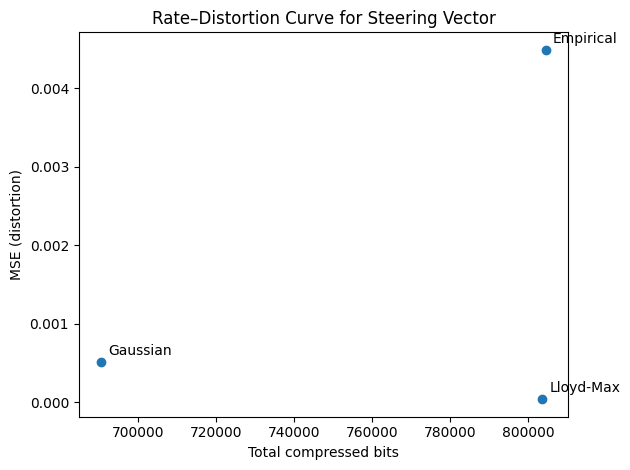

In [69]:
rates = [total_bits_gauss, total_bits_emp, total_bits_lloyd_max]
distortions = [mse_gauss, mse_emp, mse_lloyd_max]
labels = ['Gaussian', 'Empirical', 'Lloyd-Max']

plt.figure()
plt.scatter(rates, distortions)
for x, y, label in zip(rates, distortions, labels):
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(5,5))
plt.xlabel('Total compressed bits')
plt.ylabel('MSE (distortion)')
plt.title('Rate–Distortion Curve for Steering Vector')
plt.tight_layout()
plt.show()

In [ ]:
soft_prompt_rec = soft_prompt_rec.to(device)

In [ ]:
chunk_data = encode_with_soft_prompt(
    dataset, model, soft_prompt_rec)

Encoding chunks:   0%|          | 0/25 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/668 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/732 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/572 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/589 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/577 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/546 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/453 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/505 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/453 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/568 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/500 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/511 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/487 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/456 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/465 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/514 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/426 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/537 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/494 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/600 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/473 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/494 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/495 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/442 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/452 [00:00<?, ?it/s]

Encoding done in 195.64s


In [ ]:
all_rec = decode_with_soft_prompt(
    chunk_data, model, soft_prompt_rec)

Decoding chunks:   0%|          | 0/25 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/668 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/732 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/572 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/589 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/577 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/546 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/453 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/505 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/453 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/568 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/500 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/511 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/487 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/456 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/465 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/514 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/426 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/537 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/494 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/600 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/473 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/494 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/495 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/442 [00:00<?, ?it/s]

  Tokens in chunk:   0%|          | 0/452 [00:00<?, ?it/s]

Decoding done in 197.20s


In [ ]:
orig_ids = sum((entry['ids'].tolist() for entry in chunk_data), [])
encoded_output = sum([entry['bits'] for entry in chunk_data], [])

In [ ]:
compare_sequences(orig_ids, all_rec)

✅  Совпадают полностью!


In [ ]:
compression_stats(data, encoded_output)

Исходный размер:   400000 бит
Размер после сжатия: 53853 бит
Коэффициент сжатия: 0.1346
